In [39]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
import cartopy
import cartopy.crs as ccrs
from datetime import datetime
import glob
from PIL import Image

In [40]:
base_path = '/work/bk1377/a270230/'

path_ice  = base_path + 'interpolated_fesom_output/'
path_ds   = base_path + 'lkf_datasets/daily_data/'
path_imgs = base_path + 'imgs/'
path_gifs = base_path + 'imgs/gifs/'

In [41]:
lst = os.listdir(path_ds)
lst.sort()
lst

['.ipynb_checkpoints',
 'ds_2013.npy',
 'ds_2014.npy',
 'ds_2015.npy',
 'ds_2016.npy',
 'ds_2020.npy',
 'ds_2093.npy',
 'ds_2096.npy',
 'ds_2099.npy',
 'fesom_ifs']

# Plot deformation field with detected LKFs

In [7]:
def plot_def_fields(path_ds, years, i):
    
    fig = plt.figure(figsize=[16, 8])

    for col, year in zip([1,2], years):

        lkf_data = np.load(path_ds + f'ds_{year}.npy', allow_pickle=True)[0]

        ax = plt.subplot(1, 2, col, projection=ccrs.Orthographic(0, 90))

        ax.coastlines(zorder=3)
        ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

        it = lkf_data.indexes[i]

        pcm = ax.pcolormesh(lkf_data.lon[max([0,lkf_data.index_y[0][0]-1]):lkf_data.index_y[0][-1]+2:lkf_data.red_fac,
                               max([0,lkf_data.index_x[0][0]-1]):lkf_data.index_x[0][-1]+2:lkf_data.red_fac],
                      lkf_data.lat[max([0,lkf_data.index_y[0][0]-1]):lkf_data.index_y[0][-1]+2:lkf_data.red_fac,
                               max([0,lkf_data.index_x[0][0]-1]):lkf_data.index_x[0][-1]+2:lkf_data.red_fac],
                      lkf_data.calc_eps_tot(it),transform=ccrs.PlateCarree(),vmin=0,vmax=2)

        lkfs = np.load(lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(it+1))),allow_pickle=True)
        #cbar = plt.colorbar(pcm, pad=0.01, label='$\dot{\epsilon}$ /day')

        for ilkf in lkfs:
            if np.min(ilkf[:,2])<-150 and np.max(ilkf[:,2]>150):
                ilkf[ilkf[:,2]<0,2]+=360
            ax.plot(ilkf[:,2],ilkf[:,3],transform=ccrs.PlateCarree())

        day = str(lkf_data.indexes[i]+1)
        day.rjust(3 + len(day), '0')
        res = datetime.strptime(f'{year}-{day}', "%Y-%j").strftime("%m-%d-%Y")

        ax.text(0.03, 0.97, f'{res}', transform=ax.transAxes, fontsize=20,
            verticalalignment='top')
        #plt.savefig(path_imgs + 'deformation_field_lkfs.png', dpi=200, bbox_inches='tight')

    fig.tight_layout()

In [8]:
i = 0

In [9]:
years = [2013, 2093]

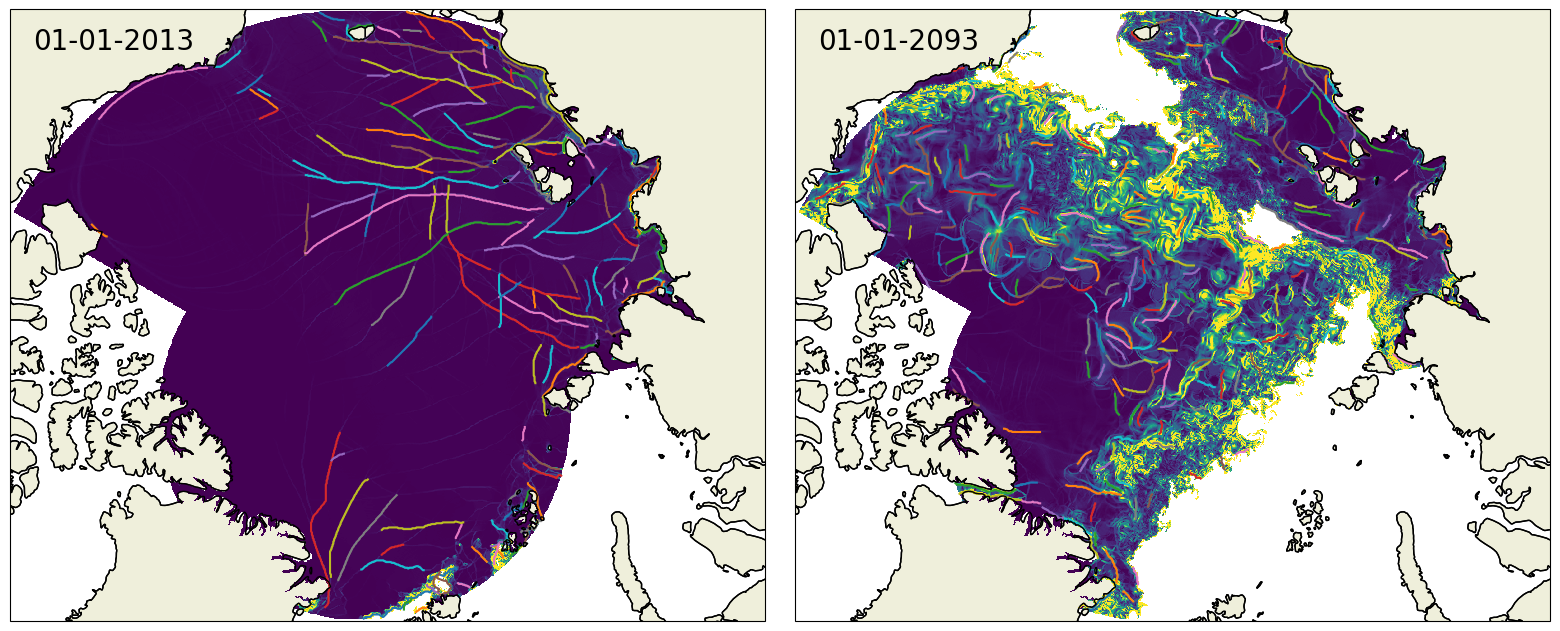

In [10]:
plot_def_fields(path_ds, years, i)

## Create LKF gif

In [11]:
ntimesteps = 3

In [12]:
for i in range(ntimesteps):
    plot_def_fields(path_ds, years, i)
    plt.savefig(path_imgs + f'deformation_fields/2013_2093/{i}.png',dpi=100,bbox_inches='tight')
    plt.close()

In [28]:
def make_gif(frame_folder, output_file):
    frames = []
    for i in range(ntimesteps):
        frames.append(Image.open(frame_folder + f'/{i}.png'))
    frame_one = frames[0]

    frame_one.save(output_file, format="GIF", append_images=frames,
                       save_all=True, duration=200, loop=1)

In [29]:
make_gif(path_imgs + 'deformation_fields/2013_2093', path_gifs + '/2013_2093_LKFs.gif')

# Plot ice field

In [42]:
i = 151

In [43]:
years = [2013, 2093]

In [44]:
def plot_ice_field(path_ice, years, i):
    
    fig = plt.figure(figsize=[16, 8])

    for col, year in zip([1,2], years):

        ice_file = xr.open_dataset(path_ice + f'ice_{year}.nc')

        ax = plt.subplot(1, 2, col, projection=ccrs.Orthographic(0, 90))
        ax.coastlines(zorder=3)
        ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
        ax.pcolormesh(ice_file.ULON, ice_file.ULAT,
                           ice_file.A.isel(time=i),
                           cmap = 'Blues_r',
                           vmin=0,vmax=1,
                           transform=ccrs.PlateCarree())

        day = str(i+1)
        day.rjust(3 + len(day), '0')
        res = datetime.strptime(f'{year}-{day}', "%Y-%j").strftime("%m-%d-%Y")

        ax.text(0.01, 0.98, f'{res}', transform=ax.transAxes, fontsize=20,
            verticalalignment='top')

    fig.tight_layout()

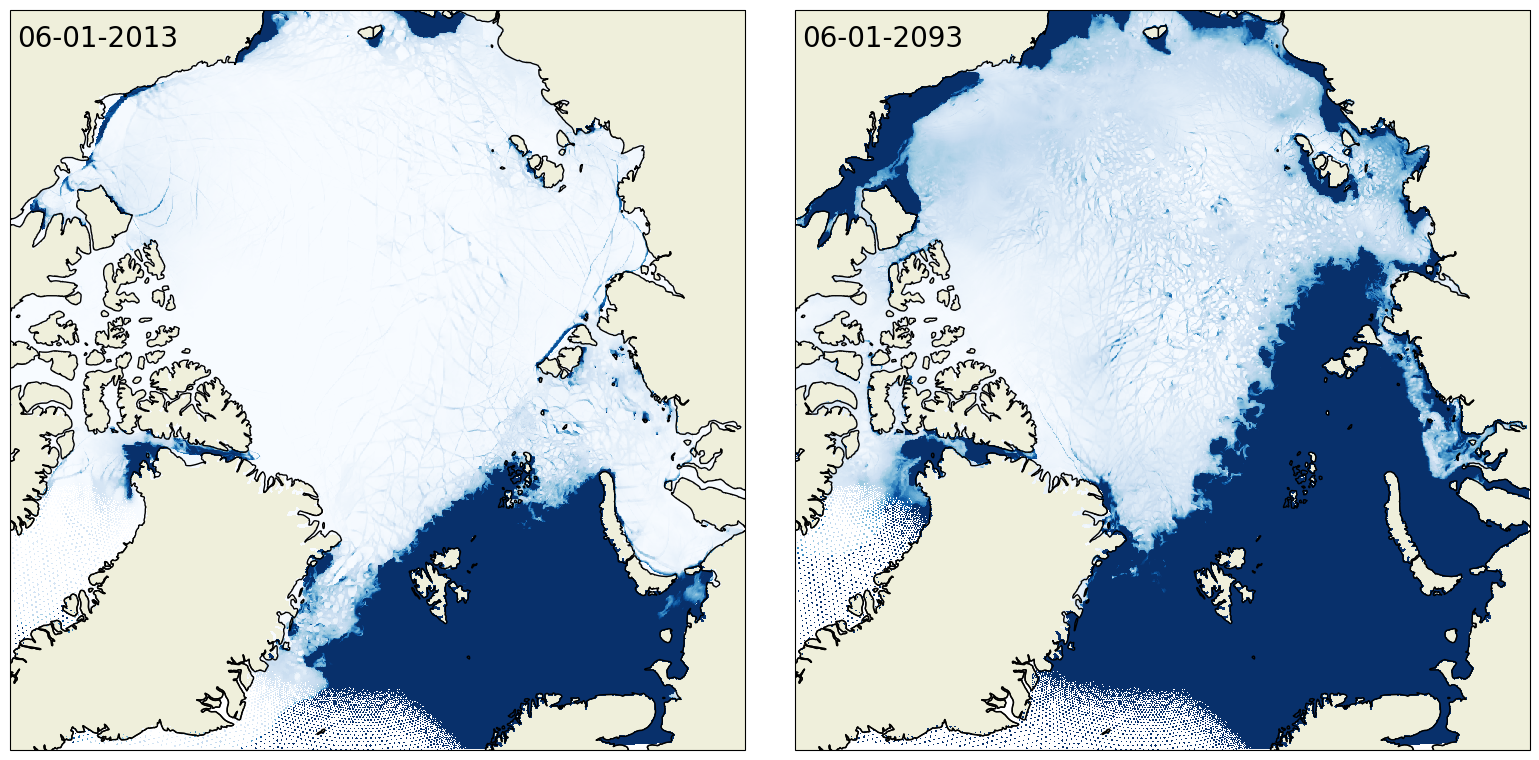

In [45]:
plot_ice_field(path_ice, years, i)

## Create ice field gif

In [46]:
ntimesteps = 3

In [47]:
for i in range(ntimesteps):
    i = i*7

    plot_ice_field(path_ice, years, i)
    
    i=int(i/7)
    plt.savefig(path_imgs + f'ice_fields/2013_2093/{i}.png',dpi=100,bbox_inches='tight')
    plt.close()

In [48]:
make_gif(path_imgs + 'ice_fields/2013_2093', path_gifs + '2013_2093_ice.gif')